# Анализ данных собранных YOLO моделью на обучающей выборке датасета

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

In [ ]:
FILE_PATH = "train_vehicle_stats_adaptive_3scale_pixels (f).xlsx"
df = pd.read_excel(FILE_PATH, sheet_name="Sheet1")
print(df.shape)
df.head()

(1071, 37)


,image_name,gsd_m_per_px,resize_factor,tile_size,overlap,tile_batch,conf_primary,count_primary,conf_fallback,count_fallback,conf_used,count_used,gsd_est_m_per_px,scale_1,scale_2,scale_3,med_len_s1_px,med_wid_s1_px,med_sqrtLW_s1_px,mean_len_s1_px,mean_wid_s1_px,mean_sqrtLW_s1_px,count_s1,med_len_s2_px,med_wid_s2_px,med_sqrtLW_s2_px,mean_len_s2_px,mean_wid_s2_px,mean_sqrtLW_s2_px,count_s2,med_len_s3_px,med_wid_s3_px,med_sqrtLW_s3_px,mean_len_s3_px,mean_wid_s3_px,mean_sqrtLW_s3_px,count_s3
0,austin1.tif,0.10,3.000000,1024,0.1,16,0.1,1747,0.01,0,0.1,1747,0.095971,1.0,0.5,0.3,48.875000,22.750000,33.343266,49.246834,22.739277,33.426983,1747,48.046875,22.031250,32.453270,48.332535,21.962753,32.549480,2026,48.281250,21.770833,32.393443,48.464661,21.748509,32.435560,1933
1,austin1.tif,0.20,1.500000,1024,0.1,16,0.1,1949,0.01,0,0.1,1949,0.197850,1.0,0.5,0.3,23.984375,10.953125,16.173861,24.059978,10.920634,16.193623,1949,24.328125,11.015625,16.390663,24.384771,11.006971,16.367126,1607,26.875000,12.317708,18.017276,26.850446,12.314732,18.167852,35
2,austin1.tif,0.29,1.034483,1024,0.1,16,0.1,1964,0.01,0,0.1,1964,0.293498,1.0,0.5,2.0,16.320312,7.300781,10.902953,16.264965,7.279613,10.869111,1964,17.875000,8.234375,12.094567,17.824003,8.251802,12.108937,455,16.953125,7.937500,11.603787,17.111334,7.918936,11.628786,1943
3,austin1.tif,0.40,0.750000,1024,0.1,16,0.1,1525,0.01,0,0.1,1525,0.390268,1.0,0.7,2.0,12.226562,5.515625,8.199497,12.273335,5.516250,8.220556,1525,13.582589,6.325335,9.276889,13.555385,6.352423,9.273932,48,12.656250,5.929688,8.636884,12.766327,5.929500,8.692733,1247
4,austin1.tif,0.50,0.600000,1024,0.1,16,0.1,742,0.01,0,0.1,742,0.464464,1.0,0.7,2.0,10.152344,4.656250,6.889655,10.186821,4.666126,6.886286,742,NaN,NaN,NaN,NaN,NaN,NaN,0,10.515625,4.929688,7.178051,10.506768,4.937602,7.196582,363


**Удаляем лишние системные столбцы**

In [ ]:
cols_to_drop = ["tile_size", "overlap", "tile_batch", "conf_primary", "conf_fallback", "resize_factor", "gsd_est_m_per_px", "scale_1",	"scale_2",	"scale_3", "conf_used"]
df = df.drop(columns=cols_to_drop, errors="ignore")
print("Новая форма df:", df.shape)
df.head()

Новая форма df: (1071, 26)


,image_name,gsd_m_per_px,count_primary,count_fallback,count_used,med_len_s1_px,med_wid_s1_px,med_sqrtLW_s1_px,mean_len_s1_px,mean_wid_s1_px,mean_sqrtLW_s1_px,count_s1,med_len_s2_px,med_wid_s2_px,med_sqrtLW_s2_px,mean_len_s2_px,mean_wid_s2_px,mean_sqrtLW_s2_px,count_s2,med_len_s3_px,med_wid_s3_px,med_sqrtLW_s3_px,mean_len_s3_px,mean_wid_s3_px,mean_sqrtLW_s3_px,count_s3
0,austin1.tif,0.10,1747,0,1747,48.875000,22.750000,33.343266,49.246834,22.739277,33.426983,1747,48.046875,22.031250,32.453270,48.332535,21.962753,32.549480,2026,48.281250,21.770833,32.393443,48.464661,21.748509,32.435560,1933
1,austin1.tif,0.20,1949,0,1949,23.984375,10.953125,16.173861,24.059978,10.920634,16.193623,1949,24.328125,11.015625,16.390663,24.384771,11.006971,16.367126,1607,26.875000,12.317708,18.017276,26.850446,12.314732,18.167852,35
2,austin1.tif,0.29,1964,0,1964,16.320312,7.300781,10.902953,16.264965,7.279613,10.869111,1964,17.875000,8.234375,12.094567,17.824003,8.251802,12.108937,455,16.953125,7.937500,11.603787,17.111334,7.918936,11.628786,1943
3,austin1.tif,0.40,1525,0,1525,12.226562,5.515625,8.199497,12.273335,5.516250,8.220556,1525,13.582589,6.325335,9.276889,13.555385,6.352423,9.273932,48,12.656250,5.929688,8.636884,12.766327,5.929500,8.692733,1247
4,austin1.tif,0.50,742,0,742,10.152344,4.656250,6.889655,10.186821,4.666126,6.886286,742,NaN,NaN,NaN,NaN,NaN,NaN,0,10.515625,4.929688,7.178051,10.506768,4.937602,7.196582,363


**Считаем количество авто найденных на разных GSD**

,gsd_m_per_px,mean,median,std,count
0,0.10,1647.359477,1488.0,1471.203198,153
1,0.20,1772.738562,1583.0,1593.815122,153
2,0.29,1701.169935,1389.0,1514.604720,153
3,0.40,1199.267974,1128.0,1059.139683,153
4,0.50,690.000000,577.0,665.066528,153
5,0.60,380.718954,274.0,407.661938,153
6,0.70,68.660131,25.0,105.637112,153


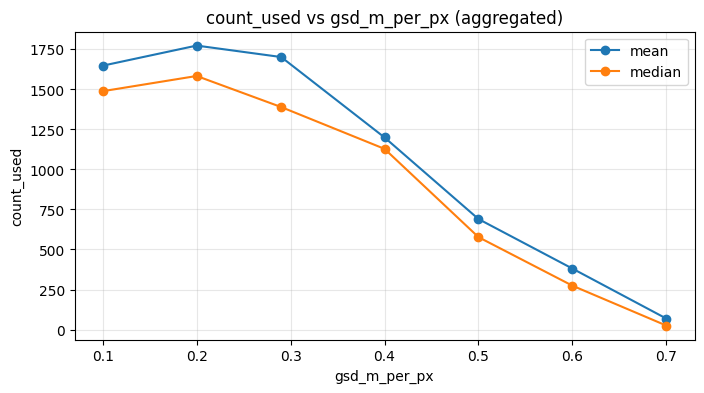

In [ ]:
g = (
    df.groupby("gsd_m_per_px")["count_used"]
      .agg(["mean", "median", "std", "count"])
      .reset_index()
      .sort_values("gsd_m_per_px")
)

display(g)

plt.figure(figsize=(8, 4))
plt.plot(g["gsd_m_per_px"], g["mean"], marker="o", label="mean")
plt.plot(g["gsd_m_per_px"], g["median"], marker="o", label="median")
plt.xlabel("gsd_m_per_px")
plt.ylabel("count_used")
plt.title("count_used vs gsd_m_per_px (aggregated)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Вывод: Чем выше значение GSD тем меньше авто найдено моделью

**Проверяем распределения метрик длины, ширины, корня из площади (в метрах)**

In [ ]:
# Рассчитываем величины в метрах (px × m/px)
df["med_len_s1"] = df["med_len_s1_px"] * df["gsd_m_per_px"]
df["med_wid_s1"] = df["med_wid_s1_px"] * df["gsd_m_per_px"]
df["med_sqrtLW_s1"] = df["med_sqrtLW_s1_px"] * df["gsd_m_per_px"]

df[["med_len_s1", "med_wid_s1", "med_sqrtLW_s1"]].describe()

,med_len_s1,med_wid_s1,med_sqrtLW_s1
count,1007.000000,1007.000000,1007.000000
mean,4.797034,2.169451,3.222042
std,0.312844,0.134749,0.196039
min,4.148438,1.843750,2.833771
25%,4.587500,2.062500,3.084189
50%,4.787500,2.169531,3.212173
75%,4.948281,2.246875,3.327941
max,6.539062,2.732813,4.255140


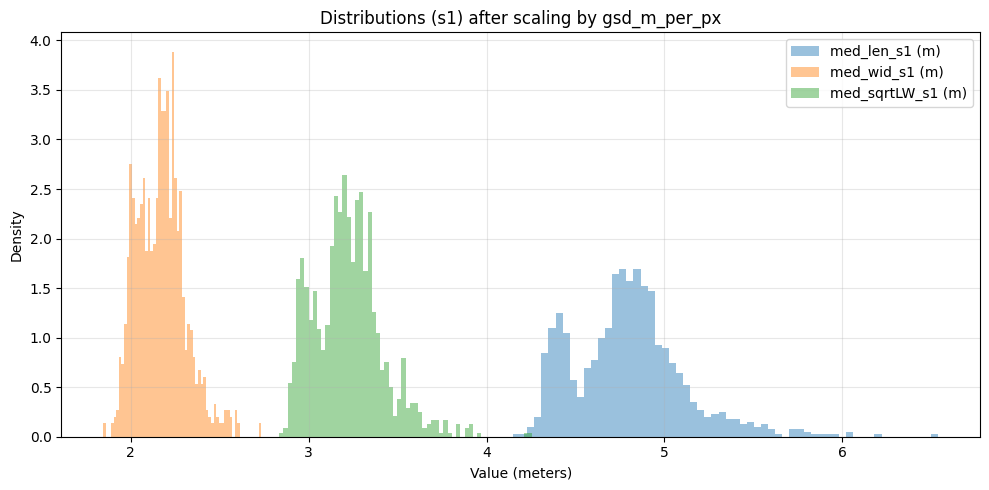

In [ ]:
vals_len = df["med_len_s1"].dropna()
vals_wid = df["med_wid_s1"].dropna()
vals_sqrt = df["med_sqrtLW_s1"].dropna()

plt.figure(figsize=(10, 5))

plt.hist(vals_len, bins=60, density=True, alpha=0.45, label="med_len_s1 (m)")
plt.hist(vals_wid, bins=60, density=True, alpha=0.45, label="med_wid_s1 (m)")
plt.hist(vals_sqrt, bins=60, density=True, alpha=0.45, label="med_sqrtLW_s1 (m)")

plt.title("Distributions (s1) after scaling by gsd_m_per_px")
plt.xlabel("Value (meters)")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Обнаружен дополнительный горб в распределении. Возможно причина в доменном сдвиге

In [ ]:
# Определяем город по вхождению подстроки в image_name
cities_list = ["vienna", "tyrol", "kitsap", "chicago", "austin"]

name_lower = df["image_name"].astype(str).str.lower()

df["city"] = "other"
for city in cities_list:
    df.loc[name_lower.str.contains(city, na=False), "city"] = city

print(df["city"].value_counts())

city
kitsap     238
tyrol      217
austin     210
chicago    203
vienna     203
Name: count, dtype: int64


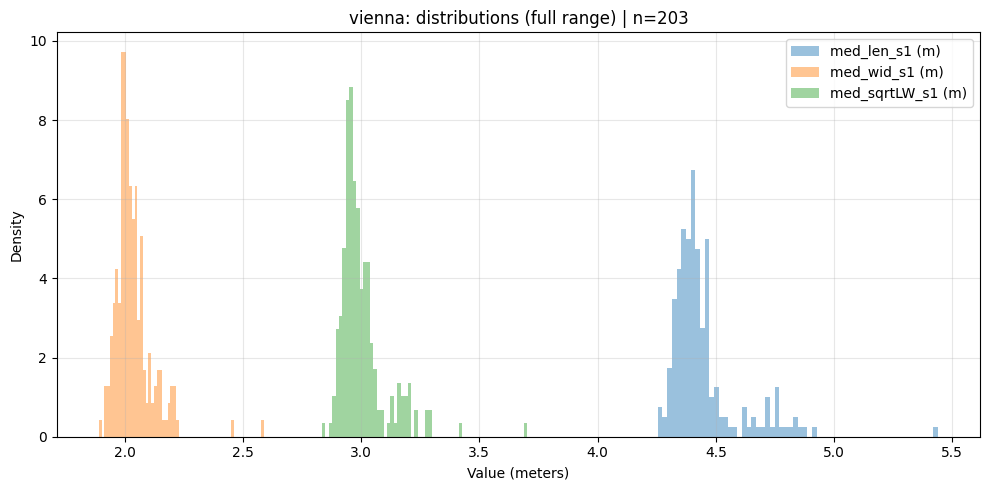

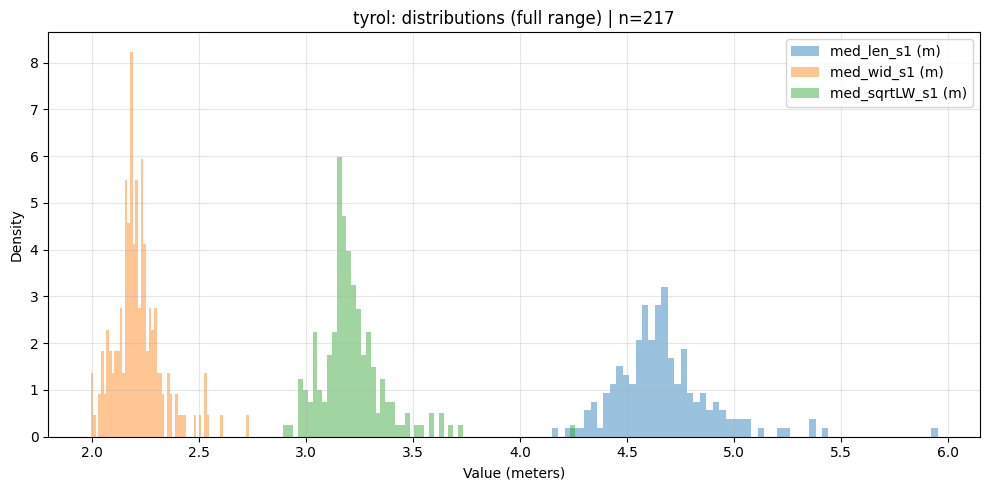

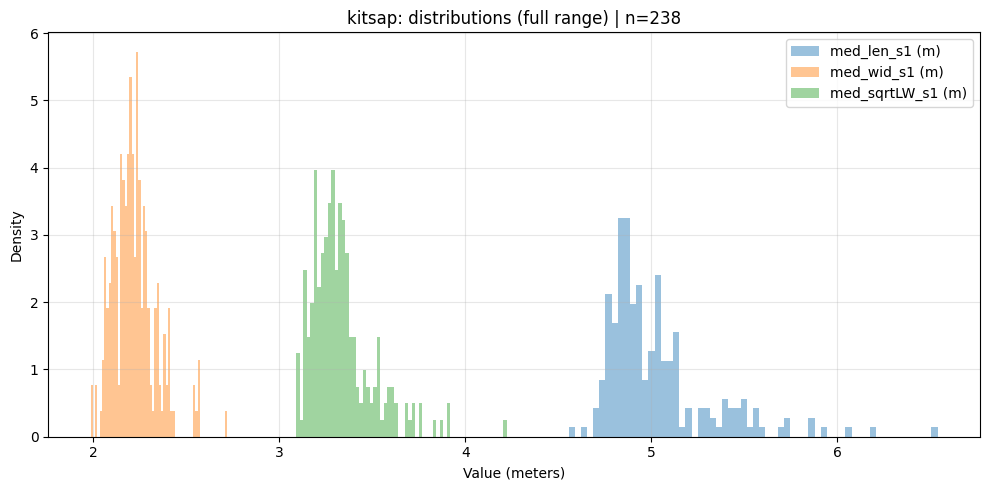

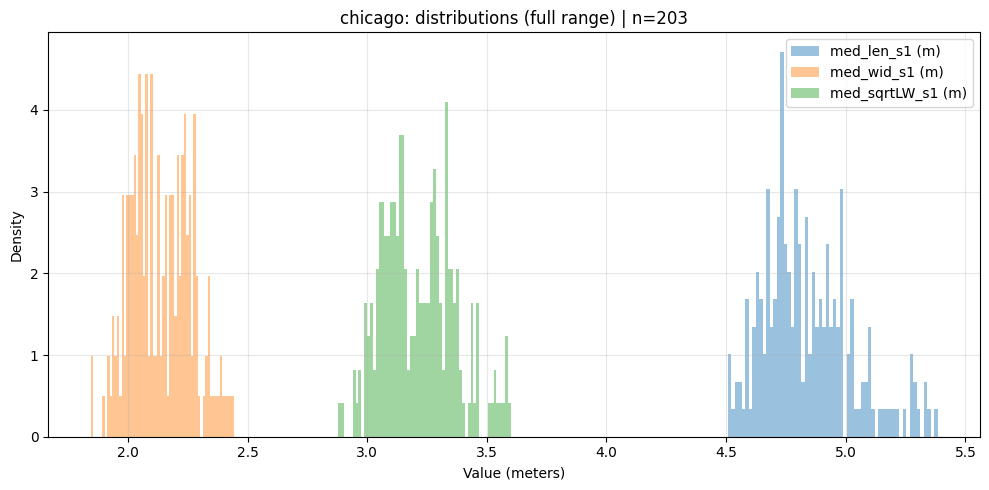

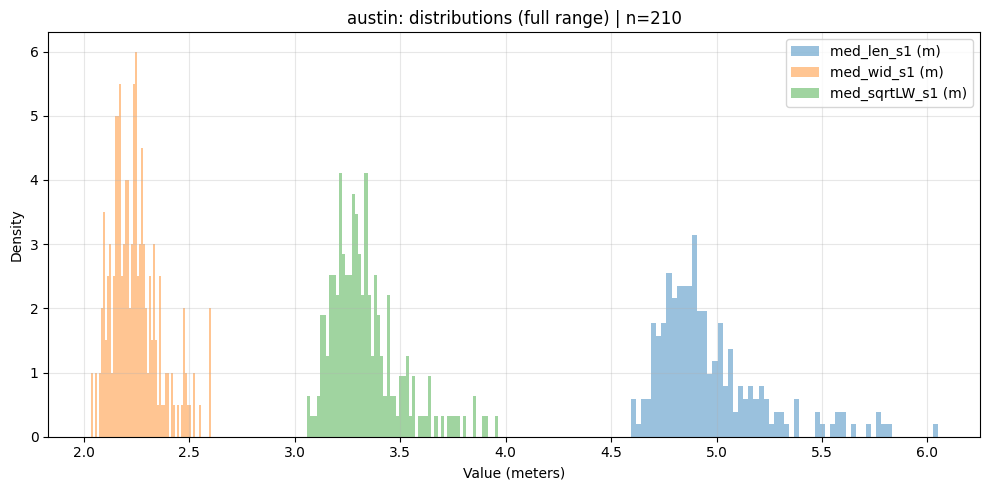

In [ ]:
# Пересчет величин (px × gsd => метры)
df["med_len_s1"] = df["med_len_s1_px"] * df["gsd_m_per_px"]
df["med_wid_s1"] = df["med_wid_s1_px"] * df["gsd_m_per_px"]
df["med_sqrtLW_s1"] = df["med_sqrtLW_s1_px"] * df["gsd_m_per_px"]

# Строим по каждому городу из списка
for city in cities_list:
    sub = df[df["city"] == city].copy()
    if len(sub) < 10:
        print(f"Skip {city}: too few rows ({len(sub)})")
        continue

    vals_len = sub["med_len_s1"].dropna()
    vals_wid = sub["med_wid_s1"].dropna()
    vals_sqrt = sub["med_sqrtLW_s1"].dropna()

    # График и по городам
    plt.figure(figsize=(10, 5))
    plt.hist(vals_len, bins=60, density=True, alpha=0.45, label="med_len_s1 (m)")
    plt.hist(vals_wid, bins=60, density=True, alpha=0.45, label="med_wid_s1 (m)")
    plt.hist(vals_sqrt, bins=60, density=True, alpha=0.45, label="med_sqrtLW_s1 (m)")

    plt.title(f"{city}: distributions (full range) | n={len(sub)}")
    plt.xlabel("Value (meters)")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Таблицы по городам
metrics = ["med_len_s1", "med_wid_s1", "med_sqrtLW_s1"]

for city in cities_list:
    sub = df[df["city"] == city][metrics].dropna(how="all")
    if len(sub) < 10:
        print(f"Skip {city}: too few rows ({len(sub)})")
        continue

    print(f"\n{city.upper()} | n={len(sub)}")
    display(sub.describe().T)


VIENNA | n=203


,count,mean,std,min,25%,50%,75%,max
med_len_s1,203.0,4.446464,0.149566,4.254844,4.360781,4.406250,4.462500,5.440039
med_wid_s1,203.0,2.035703,0.081105,1.890664,1.989141,2.018750,2.062109,2.589453
med_sqrtLW_s1,203.0,3.004339,0.103634,2.833771,2.945777,2.973885,3.024948,3.703492



TYROL | n=177


,count,mean,std,min,25%,50%,75%,max
med_len_s1,177.0,4.668818,0.231516,4.148438,4.542187,4.650000,4.757812,5.950781
med_wid_s1,177.0,2.214356,0.113981,1.992188,2.159141,2.198438,2.254688,2.732813
med_sqrtLW_s1,177.0,3.211790,0.159900,2.893356,3.140578,3.185464,3.263330,4.255140



KITSAP | n=214


,count,mean,std,min,25%,50%,75%,max
med_len_s1,214.0,5.027401,0.289321,4.554688,4.844531,4.932813,5.110938,6.539062
med_wid_s1,214.0,2.218732,0.114835,1.985156,2.147969,2.205137,2.271875,2.719727
med_sqrtLW_s1,214.0,3.334824,0.171518,3.090623,3.219897,3.296478,3.390058,4.221554



CHICAGO | n=203


,count,mean,std,min,25%,50%,75%,max
med_len_s1,203.0,4.841019,0.189319,4.506250,4.710938,4.800000,4.949063,5.383984
med_wid_s1,203.0,2.137124,0.125907,1.843750,2.039062,2.126562,2.234375,2.443164
med_sqrtLW_s1,203.0,3.213828,0.153114,2.879387,3.093391,3.198816,3.326094,3.600015



AUSTIN | n=210


,count,mean,std,min,25%,50%,75%,max
med_len_s1,210.0,4.966714,0.256802,4.592422,4.792578,4.895313,5.061523,6.048437
med_wid_s1,210.0,2.241924,0.116092,2.031699,2.162500,2.229687,2.292773,2.603125
med_sqrtLW_s1,210.0,3.334137,0.169101,3.058721,3.217802,3.298468,3.400111,3.963806


Гипотеза подтверждена. Для Вены типичны автомобили относительно небольшого размера. В рамках данного проекта (из-за ограничения по сроку) придется этим пренебречь, но как идея для улучшения адаптация расчёта к городу/стране снимка.

**Проверим количество снимков где были найдены авто на CONF 0,1 и 0,01**

In [ ]:
total_rows = len(df)

n_primary_nonzero = (df["count_primary"] != 0).sum()
n_fallback_nonzero = (df["count_fallback"] != 0).sum()

n_both_zero = ((df["count_primary"] == 0) & (df["count_fallback"] == 0)).sum()

print("Всего снимков:", total_rows)
print("Снимков где найдены авто при CONF 0,1:", n_primary_nonzero)
print("Снимков где найдены авто при CONF 0,01:", n_fallback_nonzero)
print("Снимков где не быль найдены авто:", n_both_zero)

Всего снимков: 1071
Снимков где найдены авто при CONF 0,1: 975
Снимков где найдены авто при CONF 0,01: 136
Снимков где не быль найдены авто: 30


Второй порог страхует нас в 12,7% слуаев. И всего 30 снимков где вообще не найдены авто (2,8%)

**Разработаем стратегию выбора размера из трех скейлов, которые у нас есть**

Добавим столбец с метрикой sqrtLW выбранной по максимальному количеству найденных авто на этом скейле

In [ ]:
# Определяем лучший scale по максимуму count_s1/count_s2/count_s3
best_scale = df[["count_s1", "count_s2", "count_s3"]].idxmax(axis=1)

# Создаем новый столбец: med_sqrtLW_best_px
df["med_sqrtLW_best_px"] = np.select(
    [
        best_scale == "count_s1",
        best_scale == "count_s2",
        best_scale == "count_s3",
    ],
    [
        df["med_sqrtLW_s1_px"],
        df["med_sqrtLW_s2_px"],
        df["med_sqrtLW_s3_px"],
    ],
    default=np.nan
)

# Посчитаем в метрах
df["med_sqrtLW_best_m"] = df["med_sqrtLW_best_px"] * df["gsd_m_per_px"]

df[["count_s1","count_s2","count_s3","med_sqrtLW_best_px","med_sqrtLW_best_m"]].head(10)

,count_s1,count_s2,count_s3,med_sqrtLW_best_px,med_sqrtLW_best_m
0,1747,2026,1933,32.453270,3.245327
1,1949,1607,35,16.173861,3.234772
2,1964,455,1943,10.902953,3.161856
3,1525,48,1247,8.199497,3.279799
4,742,0,363,6.889655,3.444828
5,340,69,38,5.834635,3.500781
6,25,0,1,5.379546,3.765682
7,1259,1376,1174,32.501945,3.250195
8,1326,1045,8,16.151875,3.230375
9,1228,155,1396,11.590483,3.361240


In [ ]:
# s1 в метрах
df["med_sqrtLW_s1_m"] = df["med_sqrtLW_s1_px"] * df["gsd_m_per_px"]

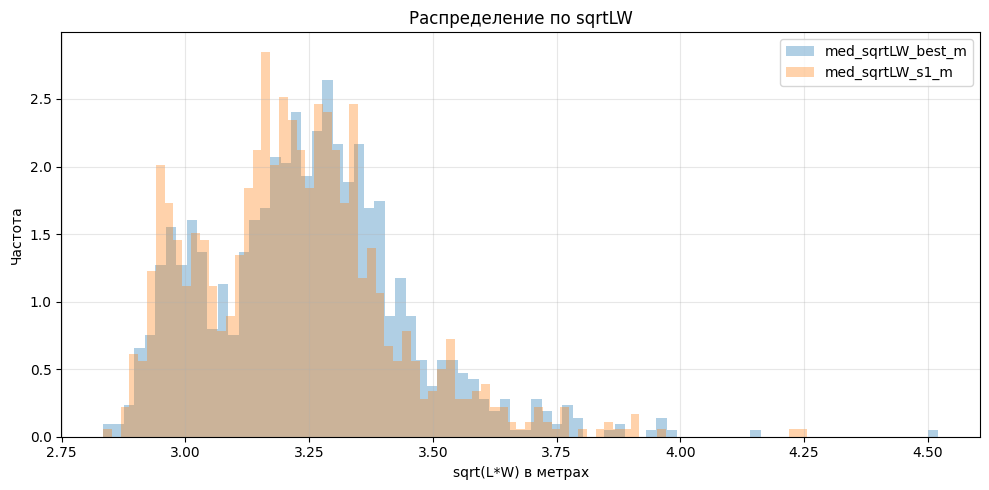

In [ ]:
vals_best = df["med_sqrtLW_best_m"].dropna()
vals_s1 = df["med_sqrtLW_s1_m"].dropna()

plt.figure(figsize=(10, 5))
plt.hist(vals_best, bins=80, density=True, alpha=0.35, label="med_sqrtLW_best_m")
plt.hist(vals_s1, bins=80, density=True, alpha=0.35, label="med_sqrtLW_s1_m")

plt.title("Распределение по sqrtLW")
plt.xlabel("sqrt(L*W) в метрах")
plt.ylabel("Частота")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Теперь применим альтернативную стратегию. Не будем выбирать один лучший s по count, а усредним все три значения с весами определяемыми на основе count_s.

In [ ]:
# Weighted sqrtLW по count: учитываем только scale, где count>0 и med не NaN

# валидность scale: count>0 и есть med
v1 = (df["count_s1"] > 0) & df["med_sqrtLW_s1_px"].notna()
v2 = (df["count_s2"] > 0) & df["med_sqrtLW_s2_px"].notna()
v3 = (df["count_s3"] > 0) & df["med_sqrtLW_s3_px"].notna()

# веса: count только для валидных scale
w1 = np.where(v1, df["count_s1"], 0)
w2 = np.where(v2, df["count_s2"], 0)
w3 = np.where(v3, df["count_s3"], 0)

# знаменатель
df["count_scales_sum"] = w1 + w2 + w3

# числитель
num = (
    df["med_sqrtLW_s1_px"].fillna(0) * w1 +
    df["med_sqrtLW_s2_px"].fillna(0) * w2 +
    df["med_sqrtLW_s3_px"].fillna(0) * w3
)

df["med_sqrtLW_weighted_px"] = np.where(
    df["count_scales_sum"] > 0,
    num / df["count_scales_sum"],
    np.nan
)

df["med_sqrtLW_weighted_m"] = df["med_sqrtLW_weighted_px"] * df["gsd_m_per_px"]

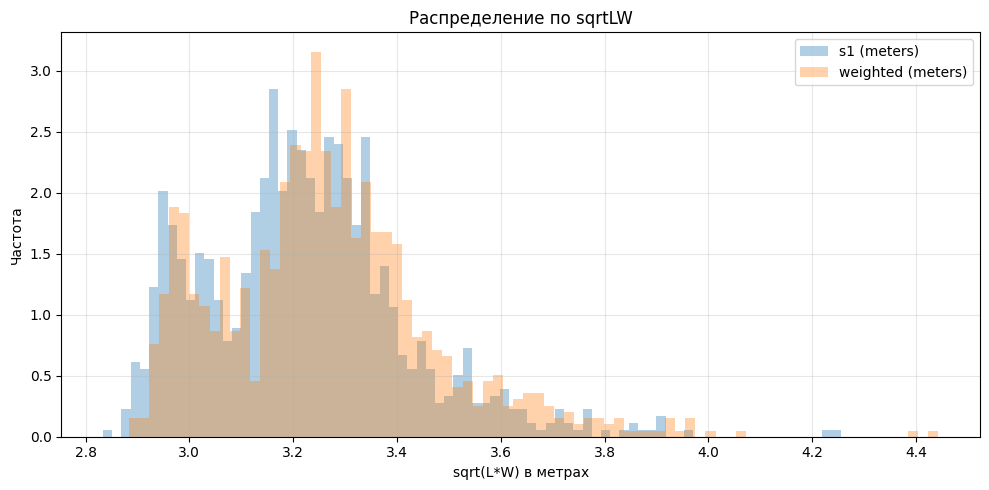

In [ ]:
vals_s1 = df["med_sqrtLW_s1_m"].dropna()
vals_best = df["med_sqrtLW_best_m"].dropna()
vals_w = df["med_sqrtLW_weighted_m"].dropna()

plt.figure(figsize=(10, 5))
plt.hist(vals_s1, bins=80, density=True, alpha=0.35, label="s1 (meters)")
# plt.hist(vals_best, bins=80, density=True, alpha=0.35, label="best-scale (meters)")
plt.hist(vals_w, bins=80, density=True, alpha=0.35, label="weighted (meters)")

plt.title("Распределение по sqrtLW")
plt.xlabel("sqrt(L*W) в метрах")
plt.ylabel("Частота")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Построим сводную таблицу по трем стратегиям: исходный масштаб, лучший по количеству найденных авто и взвешенный по количеству найденных авто

In [ ]:
strategies = {
    "S1": "med_sqrtLW_s1_m",
    "Best": "med_sqrtLW_best_m",
    "Weighted": "med_sqrtLW_weighted_m",
}

rows = []

for name, col in strategies.items():
    x = df[col].dropna()
    if len(x) == 0:
        continue

    q = x.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])

    rows.append({
        "strategy": name,
        "n": len(x),
        "mean": x.mean(),
        "std": x.std(ddof=1),
        "min": x.min(),
        "p01": q.loc[0.01],
        "p05": q.loc[0.05],
        "p25": q.loc[0.25],
        "median": q.loc[0.50],
        "p75": q.loc[0.75],
        "p95": q.loc[0.95],
        "p99": q.loc[0.99],
        "max": x.max(),
        "IQR": q.loc[0.75] - q.loc[0.25],
    })

stats_strategies = pd.DataFrame(rows).set_index("strategy")
stats_strategies


,n,mean,std,min,p01,p05,p25,median,p75,p95,p99,max,IQR
strategy,,,,,,,,,,,,,
S1,1007,3.222042,0.196039,2.833771,2.896241,2.941652,3.084189,3.212173,3.327941,3.574364,3.833110,4.255140,0.243752
Best,1007,3.247335,0.201541,2.833771,2.899417,2.949654,3.113116,3.246671,3.355754,3.583299,3.803366,4.521129,0.242637
Weighted,1007,3.265024,0.209626,2.882944,2.930509,2.965680,3.126548,3.251831,3.370555,3.651728,3.921428,4.442927,0.244008


Стабильнее всех смотрится Best

1. Самая узкая центральная зона по IQR (самая узкая “нормальная” область значений):


* Best IQR = 0.2426 (самый маленький)
* S1 IQR = 0.2438
* Weighted IQR = 0.2440

2. Самый компактный диапазон почти для всех кадров (p01–p99)

* Best: 3.803366 - 2.899417 = 0.9039 (лучше всех)
* S1: 0.9369
* Weighted: 0.9909 (хуже)

3. S1 выглядит стабильнее по std, но не на много

* S1 std = 0.196 (лучший)
* Best std = 0.202
* Weighted std = 0.210

Главная проблема стратегии Best это правый хвост. Нужно детальнее изучить кейсы которые его формируют.

In [ ]:
# Проверим правый хвост по стратегии Best
N = 20

top_best = df.nlargest(N, "med_sqrtLW_best_m")[
    ["image_name", "gsd_m_per_px",
     "count_s1","count_s2","count_s3",
     "med_sqrtLW_s1_m","med_sqrtLW_best_m","med_sqrtLW_weighted_m"]
]

display(top_best)

,image_name,gsd_m_per_px,count_s1,count_s2,count_s3,med_sqrtLW_s1_m,med_sqrtLW_best_m,med_sqrtLW_weighted_m
557,kitsap28.tif,0.5,8,2,10,4.221554,4.521129,4.442927
181,austin5.tif,0.7,15,18,18,3.849518,4.162014,4.001793
446,kitsap13.tif,0.6,4,8,13,3.624766,3.983852,3.921979
69,austin19.tif,0.7,9,0,2,3.963806,3.963806,3.889862
202,austin8.tif,0.7,16,10,20,3.894768,3.954356,3.973871
13,austin10.tif,0.7,29,28,31,3.916207,3.953490,3.966800
445,kitsap13.tif,0.5,20,0,24,3.912590,3.941245,3.928220
508,kitsap21.tif,0.5,10,0,5,3.878241,3.878241,3.835336
272,chicago19.tif,0.7,102,96,117,3.554944,3.873877,3.773569
20,austin12.tif,0.7,9,2,1,3.846705,3.846705,3.939703


Видно, что в основном в завышенных размерах оказались kitsap и austin на масштабах 0,5-0,7. Почти на всех снимках достаточно мало детекций авто, а метрика по Best часто сильно отлиается от S1.

Попробуем избавиться от хвостов добавив к стратегии Best правило переключения с исходного масштаба только если размер отличается от S1 не более чем на 10% и если увеличение количества авто на снимке существенное (>5).

In [ ]:
c1 = df["count_s1"].fillna(0)
c2 = df["count_s2"].fillna(0)
c3 = df["count_s3"].fillna(0)

m1 = df["med_sqrtLW_s1_px"]
m2 = df["med_sqrtLW_s2_px"]
m3 = df["med_sqrtLW_s3_px"]

valid_m1 = m1.notna() & (m1 > 0)

rel_diff2 = np.where(valid_m1, np.abs(m2 - m1) / m1, np.inf)
rel_diff3 = np.where(valid_m1, np.abs(m3 - m1) / m1, np.inf)

delta2 = c2 - c1
delta3 = c3 - c1

cand2 = (delta2 > 5) & (rel_diff2 <= 0.10) & m2.notna()
cand3 = (delta3 > 5) & (rel_diff3 <= 0.10) & m3.notna()

# если оба подходят — выбираем тот, где count выше
choose2 = cand2 & (~cand3 | (c2 >= c3))
choose3 = cand3 & (~cand2 | (c3 > c2))

# Best px по новой стратегии
df["med_sqrtLW_best_px"] = np.select(
    [choose2, choose3],
    [m2, m3],
    default=m1
)

# помечаем, откуда взяли значение
df["best_scale_rule"] = np.select(
    [choose2, choose3],
    ["s2", "s3"],
    default="s1"
)

# перевод в метры
df["med_sqrtLW_best_m"] = df["med_sqrtLW_best_px"] * df["gsd_m_per_px"]

df[["count_s1","count_s2","count_s3","best_scale_rule","med_sqrtLW_best_m"]].head(10)

,count_s1,count_s2,count_s3,best_scale_rule,med_sqrtLW_best_m
0,1747,2026,1933,s2,3.245327
1,1949,1607,35,s1,3.234772
2,1964,455,1943,s1,3.161856
3,1525,48,1247,s1,3.279799
4,742,0,363,s1,3.444828
5,340,69,38,s1,3.500781
6,25,0,1,s1,3.765682
7,1259,1376,1174,s2,3.250195
8,1326,1045,8,s1,3.230375
9,1228,155,1396,s3,3.361240


Снова сверим метрики

In [ ]:
strategies = {
    "S1": "med_sqrtLW_s1_m",
    "Best": "med_sqrtLW_best_m",
    "Weighted": "med_sqrtLW_weighted_m",
}

rows = []

for name, col in strategies.items():
    x = df[col].dropna()
    if len(x) == 0:
        continue

    q = x.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])

    rows.append({
        "strategy": name,
        "n": len(x),
        "mean": x.mean(),
        "std": x.std(ddof=1),
        "min": x.min(),
        "p01": q.loc[0.01],
        "p05": q.loc[0.05],
        "p25": q.loc[0.25],
        "median": q.loc[0.50],
        "p75": q.loc[0.75],
        "p95": q.loc[0.95],
        "p99": q.loc[0.99],
        "max": x.max(),
        "IQR": q.loc[0.75] - q.loc[0.25],
    })

stats_strategies = pd.DataFrame(rows).set_index("strategy")
stats_strategies

,n,mean,std,min,p01,p05,p25,median,p75,p95,p99,max,IQR
strategy,,,,,,,,,,,,,
S1,1007,3.222042,0.196039,2.833771,2.896241,2.941652,3.084189,3.212173,3.327941,3.574364,3.833110,4.255140,0.243752
Best,1007,3.242716,0.197692,2.833771,2.899417,2.949526,3.110303,3.240335,3.351638,3.580854,3.846023,4.255140,0.241334
Weighted,1007,3.265024,0.209626,2.882944,2.930509,2.965680,3.126548,3.251831,3.370555,3.651728,3.921428,4.442927,0.244008


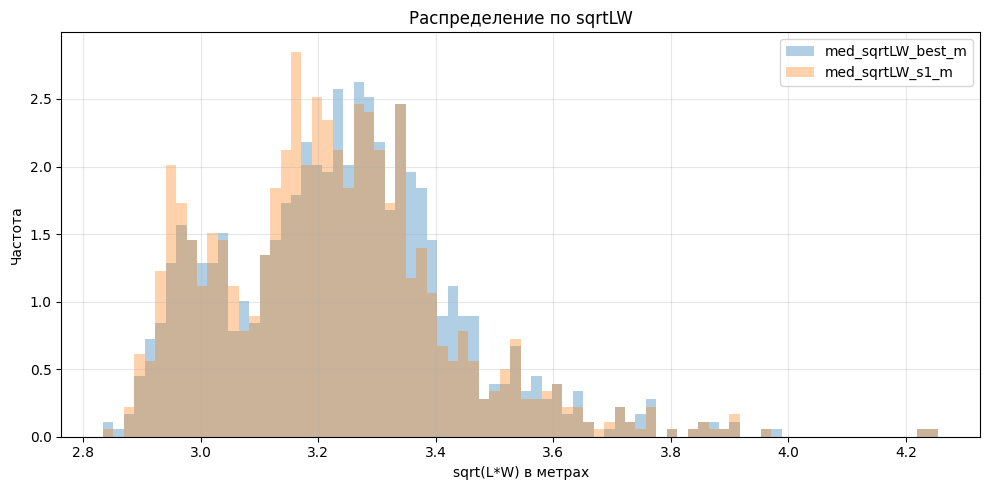

In [ ]:
vals_best = df["med_sqrtLW_best_m"].dropna()
vals_s1 = df["med_sqrtLW_s1_m"].dropna()

plt.figure(figsize=(10, 5))
plt.hist(vals_best, bins=80, density=True, alpha=0.35, label="med_sqrtLW_best_m")
plt.hist(vals_s1, bins=80, density=True, alpha=0.35, label="med_sqrtLW_s1_m")

plt.title("Распределение по sqrtLW")
plt.xlabel("sqrt(L*W) в метрах")
plt.ylabel("Частота")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Мы получили стабильное распределение (Best) без раздувание хвостов. Однако для применения этой стратегии потребуется минимум 3 операции детекции вместо одной, что затратно по времени обработки. Так что для "быстрого режима" возможно имеет смысл вернуться к стратегии S1.

**Построение прогнозной модели по стратегии S1**

In [ ]:
df

,image_name,gsd_m_per_px,count_primary,count_fallback,count_used,med_len_s1_px,med_wid_s1_px,med_sqrtLW_s1_px,mean_len_s1_px,mean_wid_s1_px,mean_sqrtLW_s1_px,count_s1,med_len_s2_px,med_wid_s2_px,med_sqrtLW_s2_px,mean_len_s2_px,mean_wid_s2_px,mean_sqrtLW_s2_px,count_s2,med_len_s3_px,med_wid_s3_px,med_sqrtLW_s3_px,mean_len_s3_px,mean_wid_s3_px,mean_sqrtLW_s3_px,count_s3,med_len_s1,med_wid_s1,med_sqrtLW_s1,city,med_sqrtLW_best_px,med_sqrtLW_best_m,med_sqrtLW_s1_m,count_scales_sum,med_sqrtLW_weighted_px,med_sqrtLW_weighted_m,best_scale_rule
0,austin1.tif,0.10,1747,0,1747,48.875000,22.750000,33.343266,49.246834,22.739277,33.426983,1747,48.046875,22.031250,32.453270,48.332535,21.962753,32.549480,2026,48.281250,21.770833,32.393443,48.464661,21.748509,32.435560,1933,4.887500,2.275000,3.334327,austin,32.453270,3.245327,3.334327,5706,32.705492,3.270549,s2
1,austin1.tif,0.20,1949,0,1949,23.984375,10.953125,16.173861,24.059978,10.920634,16.193623,1949,24.328125,11.015625,16.390663,24.384771,11.006971,16.367126,1607,26.875000,12.317708,18.017276,26.850446,12.314732,18.167852,35,4.796875,2.190625,3.234772,austin,16.173861,3.234772,3.234772,3591,16.288848,3.257770,s1
2,austin1.tif,0.29,1964,0,1964,16.320312,7.300781,10.902953,16.264965,7.279613,10.869111,1964,17.875000,8.234375,12.094567,17.824003,8.251802,12.108937,455,16.953125,7.937500,11.603787,17.111334,7.918936,11.628786,1943,4.732891,2.117227,3.161856,austin,10.902953,3.161856,3.161856,4362,11.339428,3.288434,s1
3,austin1.tif,0.40,1525,0,1525,12.226562,5.515625,8.199497,12.273335,5.516250,8.220556,1525,13.582589,6.325335,9.276889,13.555385,6.352423,9.273932,48,12.656250,5.929688,8.636884,12.766327,5.929500,8.692733,1247,4.890625,2.206250,3.279799,austin,8.199497,3.279799,3.279799,2820,8.411248,3.364499,s1
4,austin1.tif,0.50,742,0,742,10.152344,4.656250,6.889655,10.186821,4.666126,6.886286,742,NaN,NaN,NaN,NaN,NaN,NaN,0,10.515625,4.929688,7.178051,10.506768,4.937602,7.196582,363,5.076172,2.328125,3.444828,austin,6.889655,3.444828,3.444828,1105,6.984395,3.492198,s1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,vienna9.tif,0.29,2815,0,2815,14.906250,6.710938,9.995327,14.915703,6.711227,9.994806,2815,15.531250,6.949219,10.403616,15.597055,6.967113,10.404573,494,15.140625,6.906250,10.228909,15.109609,6.931727,10.223619,2472,4.322812,1.946172,2.898645,vienna,9.995327,2.898645,2.898645,5781,10.130098,2.937728,s1
1067,vienna9.tif,0.40,1621,0,1621,10.890625,4.960938,7.362758,10.920735,4.956164,7.347880,1621,11.690848,5.174386,7.831781,11.892471,5.192124,7.850366,84,11.015625,5.078125,7.451348,11.006310,5.084804,7.474776,1875,4.356250,1.984375,2.945103,vienna,7.451348,2.980539,2.945103,3580,7.420161,2.968065,s3
1068,vienna9.tif,0.50,785,0,785,8.820312,3.972656,5.913118,8.830782,3.986012,5.925110,785,8.812500,4.062500,5.981358,8.840065,4.072594,5.994424,937,8.959375,4.210938,6.134253,8.981950,4.199780,6.136627,724,4.410156,1.986328,2.956559,vienna,5.981358,2.990679,2.956559,2446,6.004713,3.002357,s2
1069,vienna9.tif,0.60,313,0,313,7.511719,3.337891,4.993159,7.562300,3.370651,5.039515,313,7.671875,3.479167,5.159734,7.664309,3.493056,5.168006,222,7.600000,3.600000,5.226039,7.627177,3.600755,5.236789,211,4.507031,2.002734,2.995896,vienna,4.993159,2.995896,2.995896,746,5.108598,3.065159,s1


In [ ]:
# Сначала очистим наш датафрейм от лишних столбцов
cols_to_drop = ["count_primary", "count_fallback", "count_used", "med_len_s2_px", "med_wid_s2_px", "med_sqrtLW_s2_px", "mean_len_s2_px", "mean_wid_s2_px",	"mean_sqrtLW_s2_px",	"count_s2", "med_len_s3_px", "med_wid_s3_px", "med_sqrtLW_s3_px", "mean_len_s3_px", "mean_wid_s3_px",	"mean_sqrtLW_s3_px",	"count_s3", "city",	"med_sqrtLW_best_px",	"med_sqrtLW_best_m",	"med_sqrtLW_s1_m",	"count_scales_sum",	"med_sqrtLW_weighted_px",	"med_sqrtLW_weighted_m",	"best_scale_rule",]
df = df.drop(columns=cols_to_drop, errors="ignore")
print("Новая форма df:", df.shape)
df.head()

Новая форма df: (1071, 12)


,image_name,gsd_m_per_px,med_len_s1_px,med_wid_s1_px,med_sqrtLW_s1_px,mean_len_s1_px,mean_wid_s1_px,mean_sqrtLW_s1_px,count_s1,med_len_s1,med_wid_s1,med_sqrtLW_s1
0,austin1.tif,0.10,48.875000,22.750000,33.343266,49.246834,22.739277,33.426983,1747,4.887500,2.275000,3.334327
1,austin1.tif,0.20,23.984375,10.953125,16.173861,24.059978,10.920634,16.193623,1949,4.796875,2.190625,3.234772
2,austin1.tif,0.29,16.320312,7.300781,10.902953,16.264965,7.279613,10.869111,1964,4.732891,2.117227,3.161856
3,austin1.tif,0.40,12.226562,5.515625,8.199497,12.273335,5.516250,8.220556,1525,4.890625,2.206250,3.279799
4,austin1.tif,0.50,10.152344,4.656250,6.889655,10.186821,4.666126,6.886286,742,5.076172,2.328125,3.444828


In [ ]:
# Найдем медиану по всем медианным длинам, ширинам и sqrtLW на s1
cols = ["med_len_s1", "med_wid_s1", "med_sqrtLW_s1"]

medians = df[cols].apply(lambda s: s[(s != 0) & s.notna()].median())

medians

,0
med_len_s1,4.787500
med_wid_s1,2.169531
med_sqrtLW_s1,3.212173


In [ ]:
# Делаем прогноз по sqrt(L*W)
TARGET_SQRTLW_M = 3.212  # эталонный sqrt(L*W) в метрах (медиана)

df["gsd_pred_sqrtlw"] = np.where(
    df["med_sqrtLW_s1_px"].notna() & (df["med_sqrtLW_s1_px"] > 0),
    TARGET_SQRTLW_M / df["med_sqrtLW_s1_px"],
    np.nan
)

df[["image_name", "gsd_m_per_px", "gsd_pred_sqrtlw"]].head(10)

,image_name,gsd_m_per_px,gsd_pred_sqrtlw
0,austin1.tif,0.10,0.096331
1,austin1.tif,0.20,0.198592
2,austin1.tif,0.29,0.294599
3,austin1.tif,0.40,0.391731
4,austin1.tif,0.50,0.466206
5,austin1.tif,0.60,0.550506
6,austin1.tif,0.70,0.597076
7,austin10.tif,0.10,0.096103
8,austin10.tif,0.20,0.198862
9,austin10.tif,0.29,0.294615


In [ ]:
# Делаем прогноз по ширине
TARGET_W_M = 2.1695  # эталонная ширина в метрах (медиана)

df["gsd_pred_w"] = np.where(
    df["med_wid_s1_px"].notna() & (df["med_wid_s1_px"] > 0),
    TARGET_W_M / df["med_wid_s1_px"],
    np.nan
)

df[["image_name", "gsd_m_per_px", "gsd_pred_w"]].head(10)

,image_name,gsd_m_per_px,gsd_pred_w
0,austin1.tif,0.10,0.095363
1,austin1.tif,0.20,0.198071
2,austin1.tif,0.29,0.297160
3,austin1.tif,0.40,0.393337
4,austin1.tif,0.50,0.465933
5,austin1.tif,0.60,0.543436
6,austin1.tif,0.70,0.594638
7,austin10.tif,0.10,0.095494
8,austin10.tif,0.20,0.199709
9,austin10.tif,0.29,0.296130


In [ ]:
# Делаем прогноз по длине
TARGET_L_M = 4.7875  # эталонная длина в метрах (медиана)

df["gsd_pred_l"] = np.where(
    df["med_len_s1_px"].notna() & (df["med_len_s1_px"] > 0),
    TARGET_L_M / df["med_len_s1_px"],
    np.nan
)

df[["image_name", "gsd_m_per_px", "gsd_pred_l"]].head(10)

,image_name,gsd_m_per_px,gsd_pred_l
0,austin1.tif,0.10,0.097954
1,austin1.tif,0.20,0.199609
2,austin1.tif,0.29,0.293346
3,austin1.tif,0.40,0.391565
4,austin1.tif,0.50,0.471566
5,austin1.tif,0.60,0.555576
6,austin1.tif,0.70,0.600784
7,austin10.tif,0.10,0.097208
8,austin10.tif,0.20,0.198061
9,austin10.tif,0.29,0.293909


In [ ]:
# Добавим столбики с относительными ошибками в %
df["err_sqrtlw"] = (df["gsd_pred_sqrtlw"] - df["gsd_m_per_px"])/df["gsd_m_per_px"]*100
df["err_w"] = (df["gsd_pred_w"] - df["gsd_m_per_px"])/df["gsd_m_per_px"]*100
df["err_l"] = (df["gsd_pred_l"] - df["gsd_m_per_px"])/df["gsd_m_per_px"]*100

df

,image_name,gsd_m_per_px,med_len_s1_px,med_wid_s1_px,med_sqrtLW_s1_px,mean_len_s1_px,mean_wid_s1_px,mean_sqrtLW_s1_px,count_s1,med_len_s1,med_wid_s1,med_sqrtLW_s1,gsd_pred_sqrtlw,gsd_pred_w,gsd_pred_l,err_sqrtlw,err_w,err_l
0,austin1.tif,0.10,48.875000,22.750000,33.343266,49.246834,22.739277,33.426983,1747,4.887500,2.275000,3.334327,0.096331,0.095363,0.097954,-3.668703,-4.637363,-2.046036
1,austin1.tif,0.20,23.984375,10.953125,16.173861,24.059978,10.920634,16.193623,1949,4.796875,2.190625,3.234772,0.198592,0.198071,0.199609,-0.703979,-0.964337,-0.195440
2,austin1.tif,0.29,16.320312,7.300781,10.902953,16.264965,7.279613,10.869111,1964,4.732891,2.117227,3.161856,0.294599,0.297160,0.293346,1.585891,2.468958,1.153827
3,austin1.tif,0.40,12.226562,5.515625,8.199497,12.273335,5.516250,8.220556,1525,4.890625,2.206250,3.279799,0.391731,0.393337,0.391565,-2.067166,-1.665722,-2.108626
4,austin1.tif,0.50,10.152344,4.656250,6.889655,10.186821,4.666126,6.886286,742,5.076172,2.328125,3.444828,0.466206,0.465933,0.471566,-6.758758,-6.813423,-5.686803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,vienna9.tif,0.29,14.906250,6.710938,9.995327,14.915703,6.711227,9.994806,2815,4.322812,1.946172,2.898645,0.321350,0.323278,0.321174,10.810402,11.475252,10.749657
1067,vienna9.tif,0.40,10.890625,4.960938,7.362758,10.920735,4.956164,7.347880,1621,4.356250,1.984375,2.945103,0.436250,0.437317,0.439598,9.062390,9.329134,9.899570
1068,vienna9.tif,0.50,8.820312,3.972656,5.913118,8.830782,3.986012,5.925110,785,4.410156,1.986328,2.956559,0.543199,0.546108,0.542781,8.639809,9.221632,8.556244
1069,vienna9.tif,0.60,7.511719,3.337891,4.993159,7.562300,3.370651,5.039515,313,4.507031,2.002734,2.995896,0.643280,0.649961,0.637337,7.213350,8.326897,6.222916


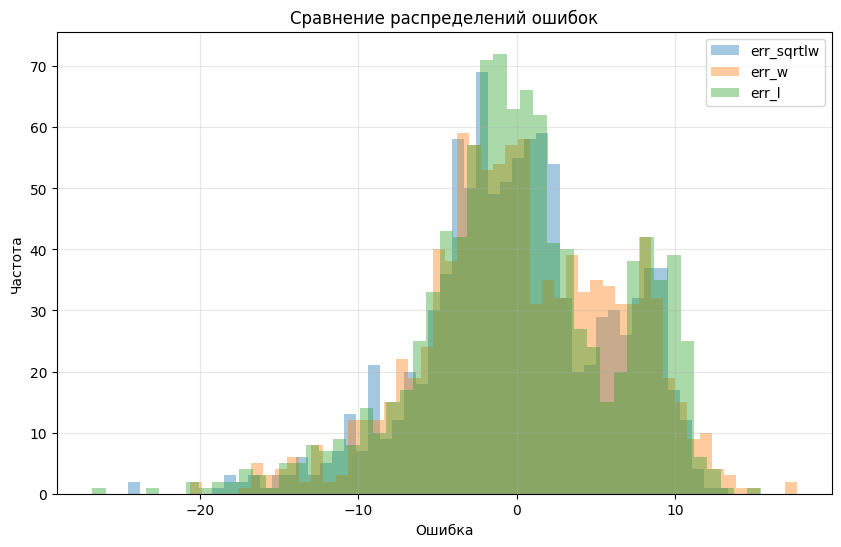

In [ ]:
cols = ["err_sqrtlw", "err_w", "err_l"]

plt.figure(figsize=(10, 6))

for c in cols:
    x = df[c].dropna()
    plt.hist(x, bins=50, alpha=0.4, label=c)

plt.title("Сравнение распределений ошибок")
plt.xlabel("Ошибка")
plt.ylabel("Частота")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
cols = ["err_sqrtlw", "err_w", "err_l"]

def summarize_err_percent(s: pd.Series) -> pd.Series:
    s = s.dropna()
    abs_s = s.abs()

    return pd.Series({
        "count": len(s),

        # Bias (смещение) — важно чтобы было близко к 0
        "bias_mean_%": s.mean(),
        "bias_median_%": s.median(),

        # Основное качество (по абсолютной % ошибке)
        "MAPE_%": abs_s.mean(),
        "MedAPE_%": abs_s.median(),

        # Вариант "штрафует сильные промахи"
        "RMSPE_%": np.sqrt((s**2).mean()),  # корень из средн.квадр.%ошибки

        # Разброс и хвосты
        "std_%": s.std(),
        "p90_abs_%": abs_s.quantile(0.90),
        "p95_abs_%": abs_s.quantile(0.95),
        "max_abs_%": abs_s.max(),

        # Доля “хороших” прогнозов
        "within_1%": (abs_s <= 1).mean(),
        "within_2%": (abs_s <= 2).mean(),
        "within_5%": (abs_s <= 5).mean(),
    })

summary = df[cols].apply(summarize_err_percent).T

# Ранги (меньше = лучше)
summary["rank_MedAPE"] = summary["MedAPE_%"].rank(method="min")
summary["rank_MAPE"] = summary["MAPE_%"].rank(method="min")
summary["rank_p95"] = summary["p95_abs_%"].rank(method="min")
summary["rank_RMSPE"] = summary["RMSPE_%"].rank(method="min")

# Итоговый скоринг (можно менять веса)
summary["score"] = (
    0.40 * summary["rank_MedAPE"] +
    0.30 * summary["rank_MAPE"] +
    0.20 * summary["rank_p95"] +
    0.10 * summary["rank_RMSPE"]
)

summary = summary.sort_values("score")
summary

,count,bias_mean_%,bias_median_%,MAPE_%,MedAPE_%,RMSPE_%,std_%,p90_abs_%,p95_abs_%,max_abs_%,within_1%,within_2%,within_5%,rank_MedAPE,rank_MAPE,rank_p95,rank_RMSPE,score
err_sqrtlw,1007.0,0.043495,-5.400142e-03,4.594436,3.668869,5.867282,5.870037,9.357024,10.843662,24.514826,0.150943,0.290963,0.614697,1.0,1.0,1.0,1.0,1.0
err_l,1007.0,0.207930,-1.387779e-14,4.849913,3.723488,6.276808,6.276480,10.168725,11.562008,26.786141,0.153923,0.306852,0.601787,2.0,2.0,2.0,3.0,2.1
err_w,1007.0,0.378639,-1.440403e-03,4.877000,4.240240,6.098576,6.089835,9.762403,11.666885,20.612922,0.144985,0.263158,0.583913,3.0,3.0,3.0,2.0,2.9


Пока что лучший sqrtlw:

лучший по MAPE

лучший по MedAPE

лучший по RMSPE

лучший по p95

лучший по within_5%

bias почти нулевой (0.04%)

**Теперь попробуем учесть зависимость типичного размера авто от количества найденных на снимке автомобилей.**

При этом следует учесть, что чем больше значение GSD тем меньше детекций независимо от снимка.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Колонки
PRED_COL  = "gsd_pred_sqrtlw"
TRUE_COL  = "gsd_m_per_px"
COUNT_COL = "count_s1"

# Подготовка обучающей выборки
d = df[[PRED_COL, TRUE_COL, COUNT_COL]].dropna().copy()

# Логарифмы требуют положительных значений
d = d[(d[PRED_COL] > 0) & (d[TRUE_COL] > 0) & (d[COUNT_COL] > 0)]

log_gsd_pred = np.log(d[PRED_COL].values.astype(float))
log_gsd_true = np.log(d[TRUE_COL].values.astype(float))
log_count    = np.log(d[COUNT_COL].values.astype(float))

# Обучение log-калибровки с interaction
# log(gsd_true) = a + b*log(gsd_pred) + c*log(count) + d*(log(gsd_pred)*log(count))
X = np.column_stack([log_gsd_pred, log_count, log_gsd_pred * log_count])
y = log_gsd_true

model = LinearRegression()
model.fit(X, y)

a = float(model.intercept_)
b, c, d_inter = [float(v) for v in model.coef_]

# Вывод формулы

print("LOG-CALIB MODEL (обучено на данных):")
print("log(gsd_true) = a + b*log(gsd_pred) + c*log(count) + d*(log(gsd_pred)*log(count))\n")

print("Коэффициенты:")
print(f"a = {a:.8f}")
print(f"b = {b:.8f}")
print(f"c = {c:.8f}")
print(f"d = {d_inter:.8f}\n")

print("Формула:")
print(
    f"log(gsd_true) = {a:.8f}"
    f" + ({b:.8f})*log(gsd_pred)"
    f" + ({c:.8f})*log(count)"
    f" + ({d_inter:.8f})*(log(gsd_pred)*log(count))"
)

# Применение к df: создаём откалиброванный прогноз масштаба
# gsd_calib = exp( log_gsd_calib )

df = df.copy()

df["log_gsd_pred"] = np.log(df[PRED_COL].clip(lower=1e-9))
df["log_count"]    = np.log(df[COUNT_COL].clip(lower=1))

df["gsd_pred_sqrtlw_calib"] = np.exp(
    a
    + b * df["log_gsd_pred"]
    + c * df["log_count"]
    + d_inter * (df["log_gsd_pred"] * df["log_count"])
)

# Удалить вспомогательные колонки
df = df.drop(columns=["log_gsd_pred", "log_count"])

# Быстрая метрика на том, где есть true

valid = df[[TRUE_COL, PRED_COL, "gsd_pred_sqrtlw_calib"]].dropna().copy()
valid = valid[valid[TRUE_COL] > 0]

err_base = (valid[PRED_COL] - valid[TRUE_COL]) / valid[TRUE_COL] * 100
err_new  = (valid["gsd_pred_sqrtlw_calib"] - valid[TRUE_COL]) / valid[TRUE_COL] * 100

print("\nMAPE, %:")
print(f"base      = {err_base.abs().mean():.4f}%")
print(f"calibrated= {err_new.abs().mean():.4f}%")

LOG-CALIB MODEL (обучено на данных):
log(gsd_true) = a + b*log(gsd_pred) + c*log(count) + d*(log(gsd_pred)*log(count))

Коэффициенты:
a = 0.11032050
b = 1.02631206
c = -0.01989536
d = -0.00519021

Формула:
log(gsd_true) = 0.11032050 + (1.02631206)*log(gsd_pred) + (-0.01989536)*log(count) + (-0.00519021)*(log(gsd_pred)*log(count))

Sanity-check (MAPE, %):
base      = 4.5944%
calibrated= 4.3114%


,count,bias_mean_%,bias_median_%,MAPE_%,MedAPE_%,RMSPE_%,std_%,p90_abs_%,p95_abs_%,max_abs_%,within_1%,within_2%,within_5%
gsd_pred_sqrtlw,1007.0,0.043495,-0.005400,4.594436,3.668869,5.867282,5.870037,9.357024,10.843662,24.514826,0.150943,0.290963,0.614697
gsd_pred_sqrtlw_calib,1007.0,0.137035,0.173021,4.311429,3.912811,5.222832,5.223628,8.072770,9.399288,19.696658,0.126117,0.256207,0.623635


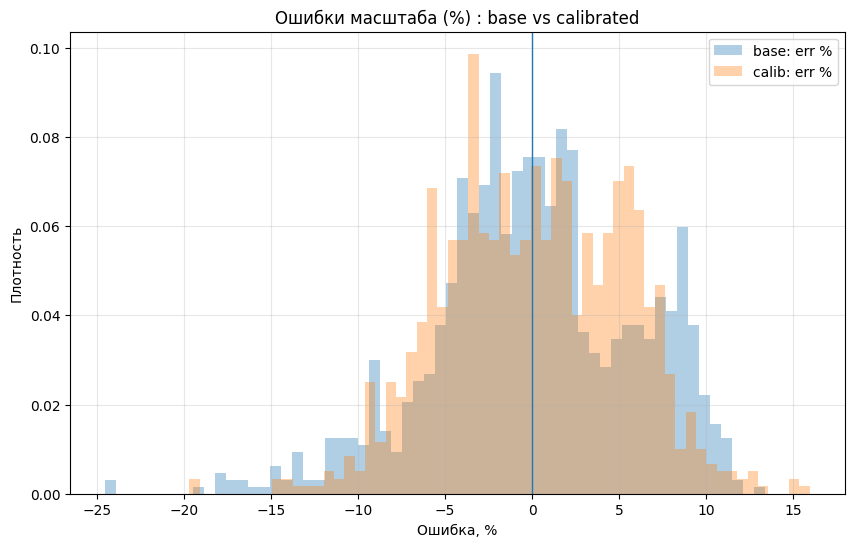

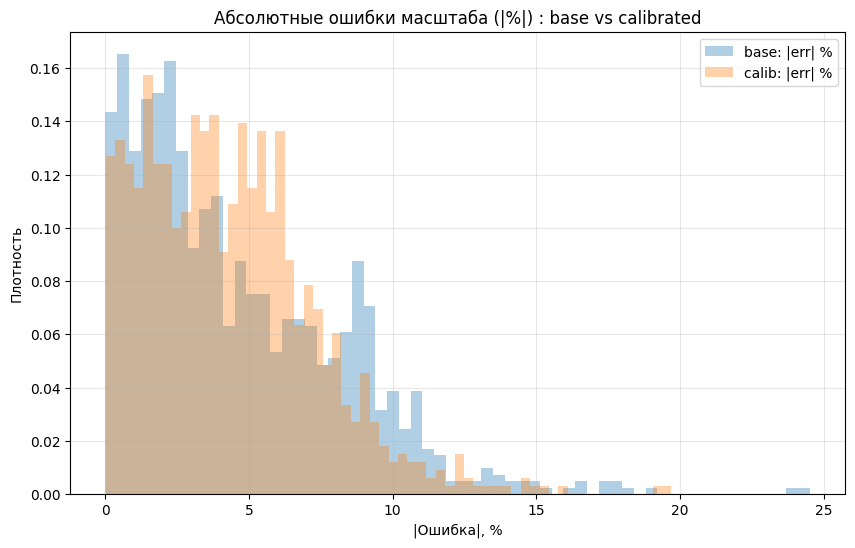

In [ ]:
PRED_BASE = "gsd_pred_sqrtlw"
PRED_CAL  = "gsd_pred_sqrtlw_calib"
TRUE_COL  = "gsd_m_per_px"

# Берём только валидные строки
d = df[[TRUE_COL, PRED_BASE, PRED_CAL]].dropna().copy()
d = d[d[TRUE_COL] > 0]

# % ошибки
d["err_base_%"] = (d[PRED_BASE] - d[TRUE_COL]) / d[TRUE_COL] * 100
d["err_cal_%"]  = (d[PRED_CAL]  - d[TRUE_COL]) / d[TRUE_COL] * 100

def summarize_err_percent(s: pd.Series) -> pd.Series:
    s = s.dropna()
    a = s.abs()
    return pd.Series({
        "count": len(s),

        "bias_mean_%": s.mean(),
        "bias_median_%": s.median(),

        "MAPE_%": a.mean(),
        "MedAPE_%": a.median(),
        "RMSPE_%": np.sqrt((s**2).mean()),

        "std_%": s.std(),

        "p90_abs_%": a.quantile(0.90),
        "p95_abs_%": a.quantile(0.95),
        "max_abs_%": a.max(),

        "within_1%": (a <= 1).mean(),
        "within_2%": (a <= 2).mean(),
        "within_5%": (a <= 5).mean(),
    })

summary = pd.DataFrame({
    "gsd_pred_sqrtlw": summarize_err_percent(d["err_base_%"]),
    "gsd_pred_sqrtlw_calib": summarize_err_percent(d["err_cal_%"]),
}).T

display(summary)

# Гистограммы ошибок (в %)

plt.figure(figsize=(10,6))
plt.hist(d["err_base_%"], bins=60, alpha=0.35, density=True, label="base: err %")
plt.hist(d["err_cal_%"],  bins=60, alpha=0.35, density=True, label="calib: err %")
plt.axvline(0, linewidth=1)
plt.title("Ошибки масштаба (%) : base vs calibrated")
plt.xlabel("Ошибка, %")
plt.ylabel("Плотность")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Гистограммы абсолютных ошибок (|%|)

plt.figure(figsize=(10,6))
plt.hist(d["err_base_%"].abs(), bins=60, alpha=0.35, density=True, label="base: |err| %")
plt.hist(d["err_cal_%"].abs(),  bins=60, alpha=0.35, density=True, label="calib: |err| %")
plt.title("Абсолютные ошибки масштаба (|%|) : base vs calibrated")
plt.xlabel("|Ошибка|, %")
plt.ylabel("Плотность")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
abs_base = d["err_base_%"].abs()
abs_cal  = d["err_cal_%"].abs()

better = (abs_cal < abs_base).mean()
worse  = (abs_cal > abs_base).mean()
same   = (abs_cal == abs_base).mean()

print("Доля улучшений:", round(better*100, 2), "%")
print("Доля ухудшений:", round(worse*100, 2), "%")
print("Равны:", round(same*100, 2), "%")

print("Среднее улучшение |err|:", round((abs_cal - abs_base).mean(), 4), "%")
print("Медианное улучшение |err|:", round((abs_cal - abs_base).median(), 4), "%")

Доля улучшений: 53.13 %
Доля ухудшений: 46.87 %
Равны: 0.0 %
Среднее улучшение |err|: -0.283 %
Медианное улучшение |err|: -0.3124 %


Сделаем небольшой шифт, чтобы вернуть центр

In [ ]:
tmp = df[["gsd_m_per_px", "gsd_pred_sqrtlw_calib"]].dropna().copy()
ratio = tmp["gsd_pred_sqrtlw_calib"] / tmp["gsd_m_per_px"]
k = 1 / ratio.mean()

df["gsd_pred_sqrtlw_calib"] = df["gsd_pred_sqrtlw_calib"] * k

print("k =", k)

k = 0.9986315218974585


И снова проверим метрики

,count,bias_mean_%,bias_median_%,MAPE_%,MedAPE_%,RMSPE_%,std_%,p90_abs_%,p95_abs_%,max_abs_%,within_1%,within_2%,within_5%
gsd_pred_sqrtlw,1007.0,4.349499e-02,-0.005400,4.594436,3.668869,5.867282,5.870037,9.357024,10.843662,24.514826,0.150943,0.290963,0.614697
gsd_pred_sqrtlw_calib,1007.0,3.612690e-15,0.035936,4.303751,3.937133,5.213889,5.216480,8.038761,9.397118,19.806551,0.124131,0.259186,0.623635


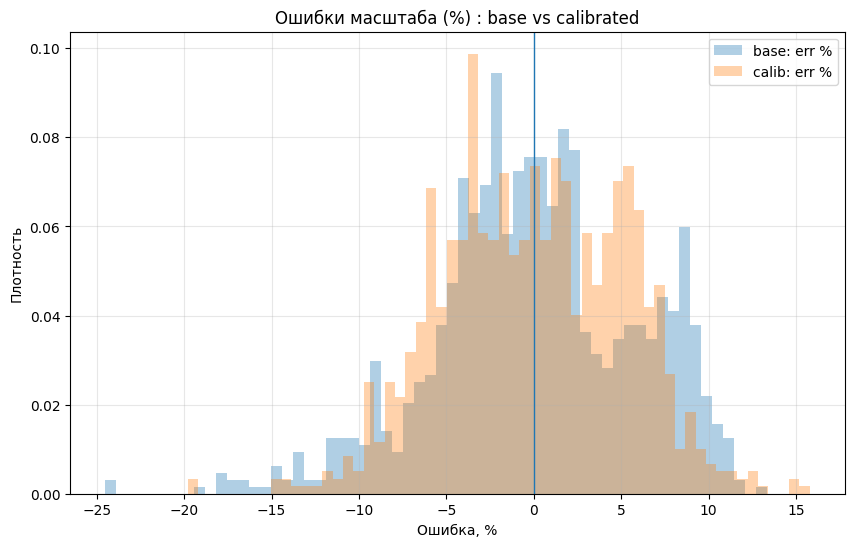

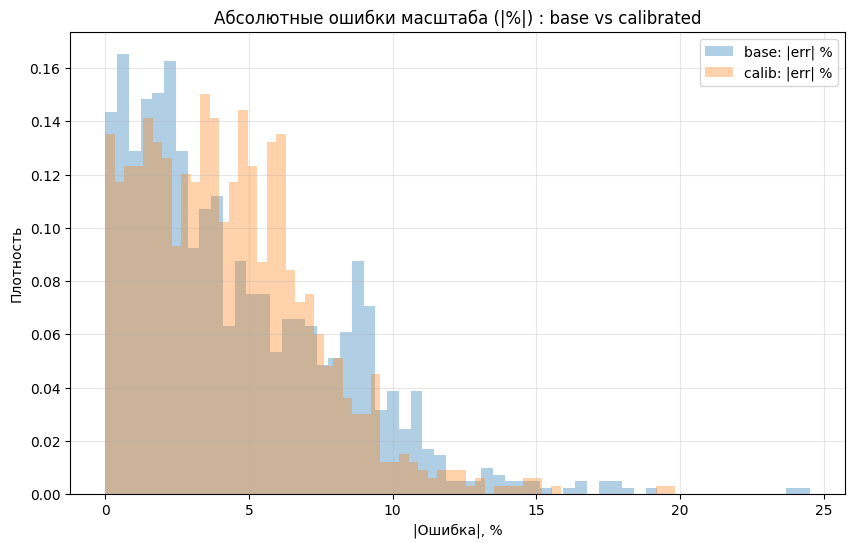

In [ ]:
PRED_BASE = "gsd_pred_sqrtlw"
PRED_CAL  = "gsd_pred_sqrtlw_calib"
TRUE_COL  = "gsd_m_per_px"

# Берём только валидные строки
d = df[[TRUE_COL, PRED_BASE, PRED_CAL]].dropna().copy()
d = d[d[TRUE_COL] > 0]

# % ошибки
d["err_base_%"] = (d[PRED_BASE] - d[TRUE_COL]) / d[TRUE_COL] * 100
d["err_cal_%"]  = (d[PRED_CAL]  - d[TRUE_COL]) / d[TRUE_COL] * 100

def summarize_err_percent(s: pd.Series) -> pd.Series:
    s = s.dropna()
    a = s.abs()
    return pd.Series({
        "count": len(s),

        "bias_mean_%": s.mean(),
        "bias_median_%": s.median(),

        "MAPE_%": a.mean(),
        "MedAPE_%": a.median(),
        "RMSPE_%": np.sqrt((s**2).mean()),

        "std_%": s.std(),

        "p90_abs_%": a.quantile(0.90),
        "p95_abs_%": a.quantile(0.95),
        "max_abs_%": a.max(),

        "within_1%": (a <= 1).mean(),
        "within_2%": (a <= 2).mean(),
        "within_5%": (a <= 5).mean(),
    })

summary = pd.DataFrame({
    "gsd_pred_sqrtlw": summarize_err_percent(d["err_base_%"]),
    "gsd_pred_sqrtlw_calib": summarize_err_percent(d["err_cal_%"]),
}).T

display(summary)

# Гистограммы ошибок (в %)

plt.figure(figsize=(10,6))
plt.hist(d["err_base_%"], bins=60, alpha=0.35, density=True, label="base: err %")
plt.hist(d["err_cal_%"],  bins=60, alpha=0.35, density=True, label="calib: err %")
plt.axvline(0, linewidth=1)
plt.title("Ошибки масштаба (%) : base vs calibrated")
plt.xlabel("Ошибка, %")
plt.ylabel("Плотность")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Гистограммы абсолютных ошибок (|%|)

plt.figure(figsize=(10,6))
plt.hist(d["err_base_%"].abs(), bins=60, alpha=0.35, density=True, label="base: |err| %")
plt.hist(d["err_cal_%"].abs(),  bins=60, alpha=0.35, density=True, label="calib: |err| %")
plt.title("Абсолютные ошибки масштаба (|%|) : base vs calibrated")
plt.xlabel("|Ошибка|, %")
plt.ylabel("Плотность")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Теперь нам надо получить степень уверенности модели для каждого предсказания**

In [ ]:
TRUE_COL = "gsd_m_per_px"
PRED_COL = "gsd_pred_sqrtlw_calib"
COUNT_COL = "count_s1"

d = df[[TRUE_COL, PRED_COL, COUNT_COL]].dropna().copy()
d = d[(d[TRUE_COL] > 0) & (d[PRED_COL] > 0) & (d[COUNT_COL] > 0)]

d["log_count"] = np.log(d[COUNT_COL])
d["log_err"]   = np.log(d[PRED_COL]) - np.log(d[TRUE_COL])                 # мультипликативная ошибка
d["pct_err"]   = (d[PRED_COL] - d[TRUE_COL]) / d[TRUE_COL] * 100           # % ошибка

q_count = 9
q_gsd   = 9

d["bin_cnt"] = pd.qcut(d["log_count"], q=q_count, duplicates="drop")
d["bin_gsd"] = pd.qcut(d[PRED_COL],     q=q_gsd,   duplicates="drop")

# RMSE по ячейкам = sqrt(mean(err^2))
grp = d.groupby(["bin_gsd", "bin_cnt"])

rmse_log = grp["log_err"].apply(lambda s: np.sqrt(np.mean(s**2))).unstack()
rmse_pct = grp["pct_err"].apply(lambda s: np.sqrt(np.mean(s**2))).unstack()
n_mat    = grp.size().unstack()

print("RMSE(log_err) table:")
display(rmse_log)

print("RMSE(% err) table:")
display(rmse_pct)

print("Counts per cell:")
display(n_mat)

RMSE(log_err) table:


/tmp/ipython-input-3470705255.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = d.groupby(["bin_gsd", "bin_cnt"])


bin_cnt,"(1.385, 2.89]","(2.89, 3.784]","(3.784, 4.751]","(4.751, 5.867]","(5.867, 6.715]","(6.715, 7.238]","(7.238, 7.671]","(7.671, 8.028]","(8.028, 8.681]"
bin_gsd,,,,,,,,,
"(0.09129999999999999, 0.103]",0.023432,0.042132,0.025009,0.033685,0.039947,0.037218,0.041110,0.037298,0.035736
"(0.103, 0.199]",0.043773,0.046223,0.033227,0.042908,0.041633,0.034511,0.039680,0.047420,0.044380
"(0.199, 0.284]",0.073236,0.039459,0.045792,0.032258,0.034779,0.042425,0.051352,0.043201,0.043165
"(0.284, 0.312]",0.028055,0.029870,0.032717,0.018450,0.017249,0.033750,0.028369,0.043192,0.043805
"(0.312, 0.415]",0.099409,0.060362,0.042833,0.038881,0.032820,0.040839,0.039208,0.047957,0.040340
"(0.415, 0.495]",0.089836,0.074177,0.073439,0.069097,0.060245,0.058843,0.067811,0.052415,0.047304
"(0.495, 0.568]",0.048902,0.049989,0.047532,0.069656,0.060497,0.062852,0.033660,NaN,NaN
"(0.568, 0.645]",0.077257,0.083575,0.073472,0.061494,0.047432,0.035495,0.048586,NaN,NaN
"(0.645, 0.79]",0.074078,0.062449,0.051312,0.051029,0.066777,NaN,NaN,NaN,NaN


RMSE(% err) table:


bin_cnt,"(1.385, 2.89]","(2.89, 3.784]","(3.784, 4.751]","(4.751, 5.867]","(5.867, 6.715]","(6.715, 7.238]","(7.238, 7.671]","(7.671, 8.028]","(8.028, 8.681]"
bin_gsd,,,,,,,,,
"(0.09129999999999999, 0.103]",2.309718,4.092997,2.462959,3.290376,3.907455,3.636944,4.021754,3.647810,3.491537
"(0.103, 0.199]",4.493452,4.584750,3.379074,4.301054,4.170211,3.489591,4.021796,4.817863,4.436963
"(0.199, 0.284]",7.391871,3.950358,4.741649,3.255557,3.563780,4.346171,5.300706,4.372568,4.356641
"(0.284, 0.312]",2.871264,3.051079,3.353292,1.871056,1.743529,3.481437,2.916754,4.444614,4.500997
"(0.312, 0.415]",9.301587,5.978962,4.237557,4.015426,3.349377,4.077179,3.815595,4.735757,3.939467
"(0.415, 0.495]",8.478685,7.223566,7.663269,6.919928,5.940766,5.865274,6.641769,5.323195,4.844914
"(0.495, 0.568]",4.973369,5.172233,4.813435,6.827574,5.995270,6.174920,3.447099,NaN,NaN
"(0.568, 0.645]",7.343021,7.928633,7.119938,5.971488,4.687869,3.572412,4.838849,NaN,NaN
"(0.645, 0.79]",7.689677,6.497482,5.194110,5.166208,6.949759,NaN,NaN,NaN,NaN


Counts per cell:


bin_cnt,"(1.385, 2.89]","(2.89, 3.784]","(3.784, 4.751]","(4.751, 5.867]","(5.867, 6.715]","(6.715, 7.238]","(7.238, 7.671]","(7.671, 8.028]","(8.028, 8.681]"
bin_gsd,,,,,,,,,
"(0.09129999999999999, 0.103]",4,7,12,16,9,11,13,19,21
"(0.103, 0.199]",6,7,9,9,5,15,13,18,30
"(0.199, 0.284]",8,9,12,10,7,7,7,20,32
"(0.284, 0.312]",9,8,11,9,5,14,9,22,25
"(0.312, 0.415]",11,13,10,5,11,13,22,24,2
"(0.415, 0.495]",12,10,5,9,21,14,30,9,2
"(0.495, 0.568]",14,14,9,16,17,27,15,0,0
"(0.568, 0.645]",26,14,12,16,30,11,3,0,0
"(0.645, 0.79]",27,26,31,22,6,0,0,0,0


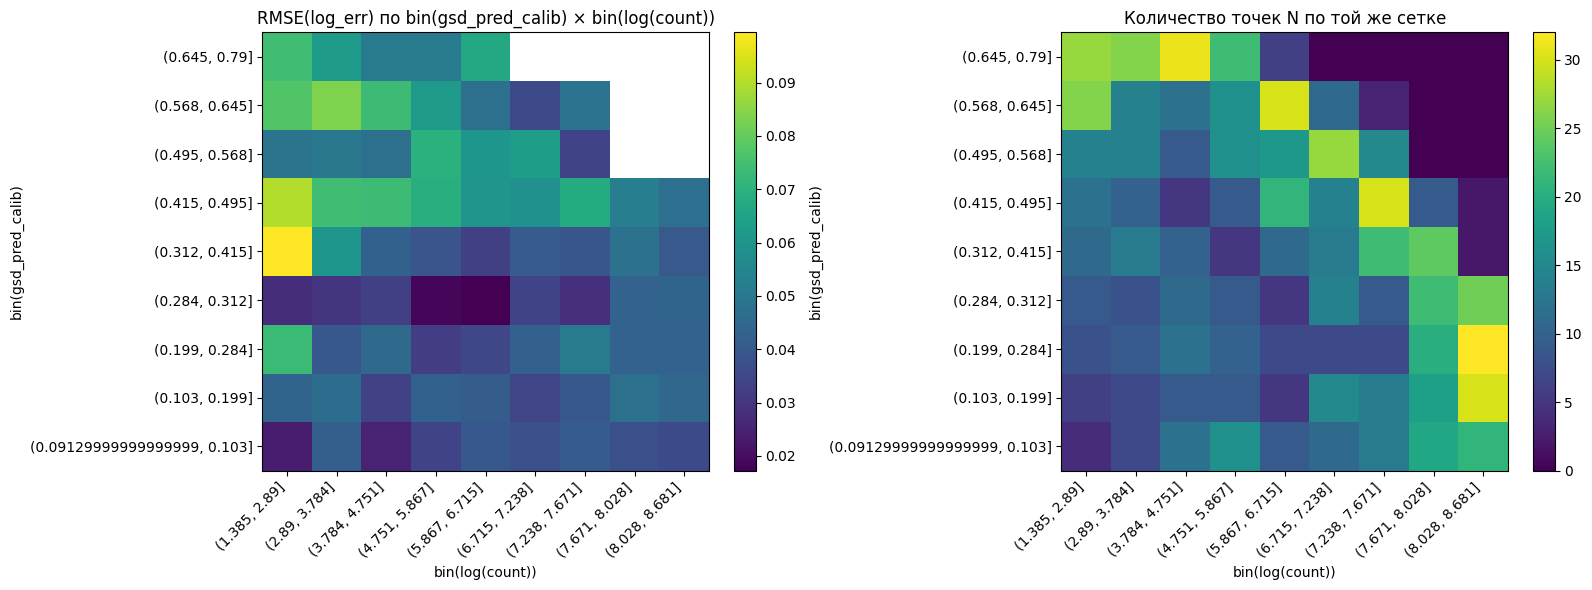

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# rmse_log: таблица (index=bin_gsd, columns=bin_cnt)
# n_mat:    таблица количества точек в ячейках

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# --- Heatmap RMSE(log_err)
im0 = ax[0].imshow(rmse_log.values, aspect="auto", origin="lower")
ax[0].set_title("RMSE(log_err) по bin(gsd_pred_calib) × bin(log(count))")
ax[0].set_xlabel("bin(log(count))")
ax[0].set_ylabel("bin(gsd_pred_calib)")
ax[0].set_xticks(range(rmse_log.shape[1]))
ax[0].set_xticklabels([str(c) for c in rmse_log.columns], rotation=45, ha="right")
ax[0].set_yticks(range(rmse_log.shape[0]))
ax[0].set_yticklabels([str(r) for r in rmse_log.index])
fig.colorbar(im0, ax=ax[0], fraction=0.046)

# --- Heatmap N (сколько точек)
im1 = ax[1].imshow(n_mat.values, aspect="auto", origin="lower")
ax[1].set_title("Количество точек N по той же сетке")
ax[1].set_xlabel("bin(log(count))")
ax[1].set_ylabel("bin(gsd_pred_calib)")
ax[1].set_xticks(range(n_mat.shape[1]))
ax[1].set_xticklabels([str(c) for c in n_mat.columns], rotation=45, ha="right")
ax[1].set_yticks(range(n_mat.shape[0]))
ax[1].set_yticklabels([str(r) for r in n_mat.index])
fig.colorbar(im1, ax=ax[1], fraction=0.046)

plt.tight_layout()
plt.show()

In [ ]:
# Центры интервалов (x = log_count, y = gsd_pred)
cnt_bins = rmse_log.columns
gsd_bins = rmse_log.index

cnt_centers = np.array([(iv.left + iv.right)/2 for iv in cnt_bins], dtype=float)
gsd_centers = np.array([(iv.left + iv.right)/2 for iv in gsd_bins], dtype=float)

Z = rmse_log.values.astype(float)  # sigma on grid

# Функция bilinear интерполяции (без scipy)
def bilinear_sigma(x, y, x_grid, y_grid, Z):
    """
    x_grid: centers по оси X (log_count), shape [nx]
    y_grid: centers по оси Y (gsd_pred),  shape [ny]
    Z:      sigma[y_idx, x_idx], shape [ny, nx]
    """
    # если вне диапазона -> обрезаем к ближайшему
    x = np.clip(x, x_grid.min(), x_grid.max())
    y = np.clip(y, y_grid.min(), y_grid.max())

    # индексы справа от x/y
    ix = np.searchsorted(x_grid, x)
    iy = np.searchsorted(y_grid, y)

    # крайние случаи
    ix1 = np.clip(ix, 1, len(x_grid)-1)
    iy1 = np.clip(iy, 1, len(y_grid)-1)

    ix0 = ix1 - 1
    iy0 = iy1 - 1

    x0, x1 = x_grid[ix0], x_grid[ix1]
    y0, y1 = y_grid[iy0], y_grid[iy1]

    # веса (0..1)
    wx = 0.0 if x1 == x0 else (x - x0) / (x1 - x0)
    wy = 0.0 if y1 == y0 else (y - y0) / (y1 - y0)

    # значения в углах
    z00 = Z[iy0, ix0]
    z01 = Z[iy0, ix1]
    z10 = Z[iy1, ix0]
    z11 = Z[iy1, ix1]

    # bilinear
    z0 = z00*(1-wx) + z01*wx
    z1 = z10*(1-wx) + z11*wx
    return z0*(1-wy) + z1*wy

# Применяем ко всему df
TRUE_COL  = "gsd_m_per_px"
PRED_COL  = "gsd_pred_sqrtlw_calib"
COUNT_COL = "count_s1"

df = df.copy()
df["log_count"] = np.log(df[COUNT_COL].clip(lower=1))

xs = df["log_count"].values.astype(float)
ys = df[PRED_COL].values.astype(float)

df["sigma_log_interp"] = np.array([bilinear_sigma(x, y, cnt_centers, gsd_centers, Z) for x, y in zip(xs, ys)])

In [ ]:
df["sigma_pct_approx"] = 100 * (np.exp(df["sigma_log_interp"]) - 1)

In [ ]:
df

,image_name,gsd_m_per_px,med_len_s1_px,med_wid_s1_px,med_sqrtLW_s1_px,mean_len_s1_px,mean_wid_s1_px,mean_sqrtLW_s1_px,count_s1,med_len_s1,med_wid_s1,med_sqrtLW_s1,gsd_pred_sqrtlw,gsd_pred_w,gsd_pred_l,err_sqrtlw,err_w,err_l,log_gsd_pred,log_count,gsd_pred_sqrtlw_calib,sigma_log_interp,sigma_pct_approx
0,austin1.tif,0.10,48.875000,22.750000,33.343266,49.246834,22.739277,33.426983,1747,4.887500,2.275000,3.334327,0.096331,0.095363,0.097954,-3.668703,-4.637363,-2.046036,-2.339962,7.465655,0.095327,0.041002,4.185462
1,austin1.tif,0.20,23.984375,10.953125,16.173861,24.059978,10.920634,16.193623,1949,4.796875,2.190625,3.234772,0.198592,0.198071,0.199609,-0.703979,-0.964337,-0.195440,-1.616503,7.575072,0.194516,0.045322,4.636510
2,austin1.tif,0.29,16.320312,7.300781,10.902953,16.264965,7.279613,10.869111,1964,4.732891,2.117227,3.161856,0.294599,0.297160,0.293346,1.585891,2.468958,1.153827,-1.222140,7.582738,0.287047,0.036191,3.685346
3,austin1.tif,0.40,12.226562,5.515625,8.199497,12.273335,5.516250,8.220556,1525,4.890625,2.206250,3.279799,0.391731,0.393337,0.391565,-2.067166,-1.665722,-2.108626,-0.937179,7.329750,0.381722,0.044779,4.579679
4,austin1.tif,0.50,10.152344,4.656250,6.889655,10.186821,4.666126,6.886286,742,5.076172,2.328125,3.444828,0.466206,0.465933,0.471566,-6.758758,-6.813423,-5.686803,-0.763127,6.609349,0.458602,0.059688,6.150561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,vienna9.tif,0.29,14.906250,6.710938,9.995327,14.915703,6.711227,9.994806,2815,4.322812,1.946172,2.898645,0.321350,0.323278,0.321174,10.810402,11.475252,10.749657,-1.135224,7.942718,0.311185,0.043958,4.493883
1067,vienna9.tif,0.40,10.890625,4.960938,7.362758,10.920735,4.956164,7.347880,1621,4.356250,1.984375,2.945103,0.436250,0.437317,0.439598,9.062390,9.329134,9.899570,-0.829541,7.390799,0.424163,0.057452,5.913460
1068,vienna9.tif,0.50,8.820312,3.972656,5.913118,8.830782,3.986012,5.925110,785,4.410156,1.986328,2.956559,0.543199,0.546108,0.542781,8.639809,9.221632,8.556244,-0.610279,6.665684,0.533184,0.061316,6.323447
1069,vienna9.tif,0.60,7.511719,3.337891,4.993159,7.562300,3.370651,5.039515,313,4.507031,2.002734,2.995896,0.643280,0.649961,0.637337,7.213350,8.326897,6.222916,-0.441175,5.746203,0.640826,0.056101,5.770499


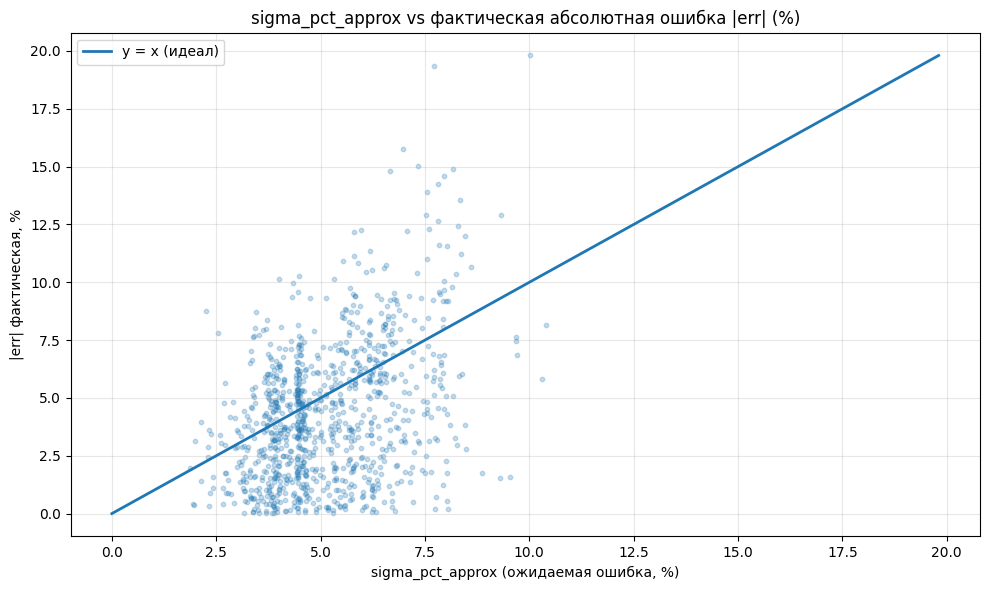

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

TRUE_COL  = "gsd_m_per_px"
PRED_COL  = "gsd_pred_sqrtlw_calib"

# Берём валидные строки
d = df[[TRUE_COL, PRED_COL, "sigma_pct_approx"]].dropna().copy()
d = d[(d[TRUE_COL] > 0) & (d[PRED_COL] > 0)]

# Фактическая абсолютная ошибка в %
d["abs_err_%"] = ((d[PRED_COL] - d[TRUE_COL]) / d[TRUE_COL]).abs() * 100

x = d["sigma_pct_approx"].values
y = d["abs_err_%"].values

plt.figure(figsize=(10,6))
plt.scatter(x, y, s=10, alpha=0.25)

# Линия y=x
m = max(np.nanmax(x), np.nanmax(y))
plt.plot([0, m], [0, m], linewidth=2, label="y = x (идеал)")

plt.title("sigma_pct_approx vs фактическая абсолютная ошибка |err| (%)")
plt.xlabel("sigma_pct_approx (ожидаемая ошибка, %)")
plt.ylabel("|err| фактическая, %")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

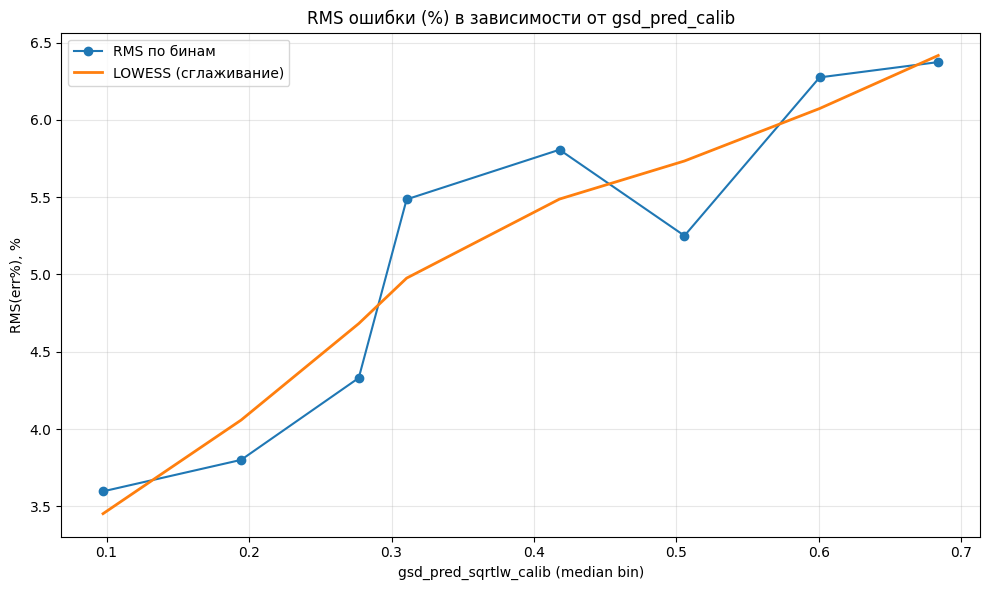

,bin_pred,rms_err_%,pred_mid,n
0,"(0.09129999999999999, 0.105]",3.597413,0.097526,126
1,"(0.105, 0.205]",3.801018,0.194439,126
2,"(0.205, 0.292]",4.330857,0.277003,126
3,"(0.292, 0.389]",5.485960,0.310615,126
4,"(0.389, 0.466]",5.806929,0.417921,125
5,"(0.466, 0.55]",5.250707,0.505611,126
6,"(0.55, 0.636]",6.274750,0.600466,126
7,"(0.636, 0.79]",6.373773,0.683733,126


In [ ]:
import statsmodels.api as sm

TRUE_COL = "gsd_m_per_px"
PRED_COL = "gsd_pred_sqrtlw_calib"

d = df[[TRUE_COL, PRED_COL]].dropna().copy()
d = d[(d[TRUE_COL] > 0) & (d[PRED_COL] > 0)]

# % ошибка
d["err_%"] = (d[PRED_COL] - d[TRUE_COL]) / d[TRUE_COL] * 100

# биннинг по предсказанию
q = 8
d["bin_pred"] = pd.qcut(d[PRED_COL], q=q, duplicates="drop")

g = (
    d.groupby("bin_pred", observed=True)["err_%"]
    .apply(lambda s: np.sqrt(np.mean(s**2)))
    .reset_index(name="rms_err_%")
)

g["pred_mid"] = d.groupby("bin_pred", observed=True)[PRED_COL].median().values
g["n"] = d.groupby("bin_pred", observed=True).size().values

# LOWESS сглаживание
low = sm.nonparametric.lowess(g["rms_err_%"], g["pred_mid"], frac=0.7, return_sorted=True)

plt.figure(figsize=(10,6))
plt.plot(g["pred_mid"], g["rms_err_%"], marker="o", label="RMS по бинам")
plt.plot(low[:,0], low[:,1], linewidth=2, label="LOWESS (сглаживание)")

plt.title("RMS ошибки (%) в зависимости от gsd_pred_calib")
plt.xlabel("gsd_pred_sqrtlw_calib (median bin)")
plt.ylabel("RMS(err%), %")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

display(g)